In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from statsmodels.graphics import tsaplots
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set(rc = {'figure.figsize':(15, 7)})
sns.set_style('white')
pd.set_option('display.max_columns', 500)

# Setting Up

In [6]:
# setting the dataframes

housing = pd.read_csv('./data/Ames_Housing_Price_Data.csv', index_col=0)
realty = pd.read_csv('./data/Ames_Real_Estate_Data.csv', index_col=0)
housing.shape

(2580, 81)

##### Cleaning up raw data

In [7]:
housing = housing.reset_index().drop('index', axis = 1)
housing.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,NaN,7890,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,NaN,NaN,NaN,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,NaN,NaN,NaN,0,2,2009,WD,Normal
2,911128020,1001,124900,30,C (all),60.0,6060,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,NaN,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,NaN,NaN,NaN,0,11,2007,WD,Normal
3,535377150,1039,114000,70,RL,80.0,8146,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,NaN,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,NaN,NaN,NaN,0,5,2009,WD,Normal
4,534177230,1665,227000,60,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,NaN,NaN,NaN,0,11,2009,WD,Normal


##### Assigning Variables

In [8]:
# filling na to 0

cols = housing.columns[housing.isna().any()].to_list()

for col in cols:
    housing[col] = housing[col].fillna(0)

In [10]:
for col in housing.columns:
    print(f'{col}: {len(housing[col].value_counts())}')

PID: 2579
GrLivArea: 1213
SalePrice: 870
MSSubClass: 16
MSZoning: 7
LotFrontage: 127
LotArea: 1753
Street: 2
Alley: 3
LotShape: 4
LandContour: 4
Utilities: 2
LotConfig: 5
LandSlope: 3
Neighborhood: 28
Condition1: 9
Condition2: 8
BldgType: 5
HouseStyle: 8
OverallQual: 10
OverallCond: 9
YearBuilt: 114
YearRemodAdd: 61
RoofStyle: 6
RoofMatl: 7
Exterior1st: 15
Exterior2nd: 16
MasVnrType: 5
MasVnrArea: 416
ExterQual: 4
ExterCond: 5
Foundation: 6
BsmtQual: 6
BsmtCond: 6
BsmtExposure: 5
BsmtFinType1: 7
BsmtFinSF1: 927
BsmtFinType2: 7
BsmtFinSF2: 264
BsmtUnfSF: 1060
TotalBsmtSF: 989
Heating: 6
HeatingQC: 5
CentralAir: 2
Electrical: 5
1stFlrSF: 1026
2ndFlrSF: 592
LowQualFinSF: 30
BsmtFullBath: 4
BsmtHalfBath: 3
FullBath: 5
HalfBath: 3
BedroomAbvGr: 7
KitchenAbvGr: 4
KitchenQual: 5
TotRmsAbvGrd: 12
Functional: 7
Fireplaces: 5
FireplaceQu: 6
GarageType: 7
GarageYrBlt: 101
GarageFinish: 4
GarageCars: 6
GarageArea: 573
GarageQual: 6
GarageCond: 6
PavedDrive: 3
WoodDeckSF: 372
OpenPorchSF: 239
Enclo

In [15]:
# when we want to start ordinals...

# housing['Street'] = housing['Street'].apply(lambda x: 1 if x == 'Pave' else 2)
# housing['Alley'] = housing['Alley'].apply(lambda x: 1 if x == 'Pave' else 2 if x == 'Grvl' else x)

In [16]:
housing['Alley'].value_counts()

0       2412
Grvl     105
Pave      63
Name: Alley, dtype: int64

# EDA

In [17]:
housing.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,909176150,856,126000,30,RL,0.0,7890,Pave,0,Reg,Lvl,AllPub,Corner,Gtl,SWISU,Norm,Norm,1Fam,1Story,6,6,1939,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,238.0,Unf,0.0,618.0,856.0,GasA,TA,Y,SBrkr,856,0,0,1.0,0.0,1,0,2,1,TA,4,Typ,1,Gd,Detchd,1939.0,Unf,2.0,399.0,TA,TA,Y,0,0,0,0,166,0,0,0,0,0,3,2010,WD,Normal
1,905476230,1049,139500,120,RL,42.0,4235,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,1Story,5,5,1984,1984,Gable,CompShg,HdBoard,HdBoard,BrkFace,149.0,Gd,TA,CBlock,Gd,TA,Mn,GLQ,552.0,ALQ,393.0,104.0,1049.0,GasA,TA,Y,SBrkr,1049,0,0,1.0,0.0,2,0,2,1,Gd,5,Typ,0,0,Attchd,1984.0,Fin,1.0,266.0,TA,TA,Y,0,105,0,0,0,0,0,0,0,0,2,2009,WD,Normal
2,911128020,1001,124900,30,C (all),60.0,6060,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,1Story,5,9,1930,2007,Hip,CompShg,MetalSd,MetalSd,None,0.0,Gd,TA,BrkTil,TA,TA,No,ALQ,737.0,Unf,0.0,100.0,837.0,GasA,Ex,Y,SBrkr,1001,0,0,0.0,0.0,1,0,2,1,Gd,5,Typ,0,0,Detchd,1930.0,Unf,1.0,216.0,TA,Po,N,154,0,42,86,0,0,0,0,0,0,11,2007,WD,Normal
3,535377150,1039,114000,70,RL,80.0,8146,Pave,0,Reg,Lvl,AllPub,Corner,Gtl,OldTown,Norm,Norm,1Fam,2Story,4,8,1900,2003,Gable,CompShg,MetalSd,MetalSd,None,0.0,Gd,Gd,BrkTil,Fa,TA,No,Unf,0.0,Unf,0.0,405.0,405.0,GasA,Gd,Y,SBrkr,717,322,0,0.0,0.0,1,0,2,1,TA,6,Typ,0,0,Detchd,1940.0,Unf,1.0,281.0,TA,TA,N,0,0,168,0,111,0,0,0,0,0,5,2009,WD,Normal
4,534177230,1665,227000,60,RL,70.0,8400,Pave,0,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,2Story,8,6,2001,2001,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,TA,No,GLQ,643.0,Unf,0.0,167.0,810.0,GasA,Ex,Y,SBrkr,810,855,0,1.0,0.0,2,1,3,1,Gd,6,Typ,0,0,Attchd,2001.0,Fin,2.0,528.0,TA,TA,Y,0,45,0,0,0,0,0,0,0,0,11,2009,WD,Normal


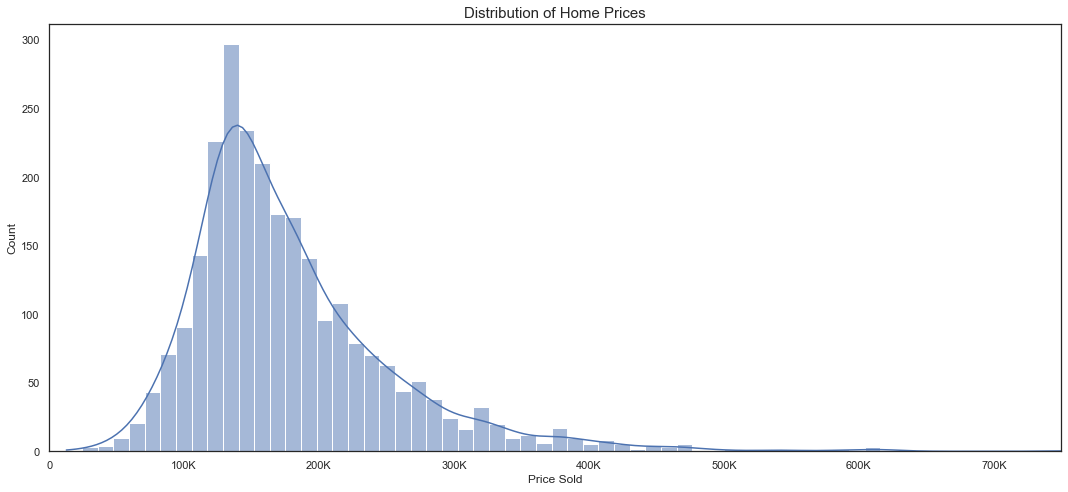

In [18]:
# distribution of house prices

fig = sns.histplot(x = 'SalePrice', data = housing, kde=True)
fig.set(xlim = (0, 7.5e5), xlabel = 'Price Sold', 
        xticklabels = ['0', '100K', '200K', '300K', 
                       '400K', '500K', '600K', '700K'])
plt.title('Distribution of Home Prices', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - PriceSold, Histogram.png', dpi = 600)
plt.show()

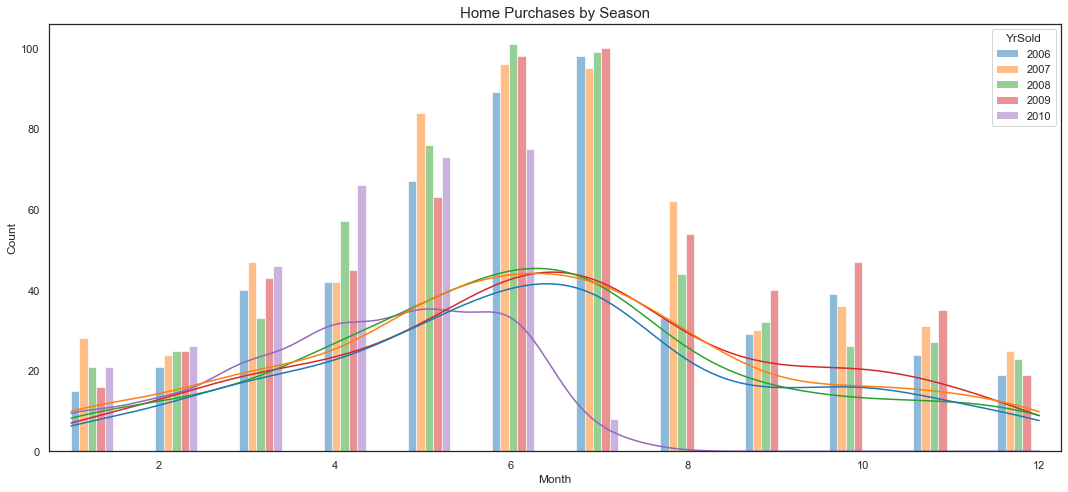

In [34]:
# seasonal prices by year

fig = sns.histplot(x="MoSold", data=housing, multiple='dodge', kde = True,
                   hue='YrSold', bins = 23, stat='count', palette='tab10')
fig.set(xlim = (0.75, 12.25), xlabel = 'Month')

# plt.legend(title = 'Year Sold')
plt.title('Home Purchases by Season', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - CountByYear, HistKDE.png', dpi = 600)
plt.show()

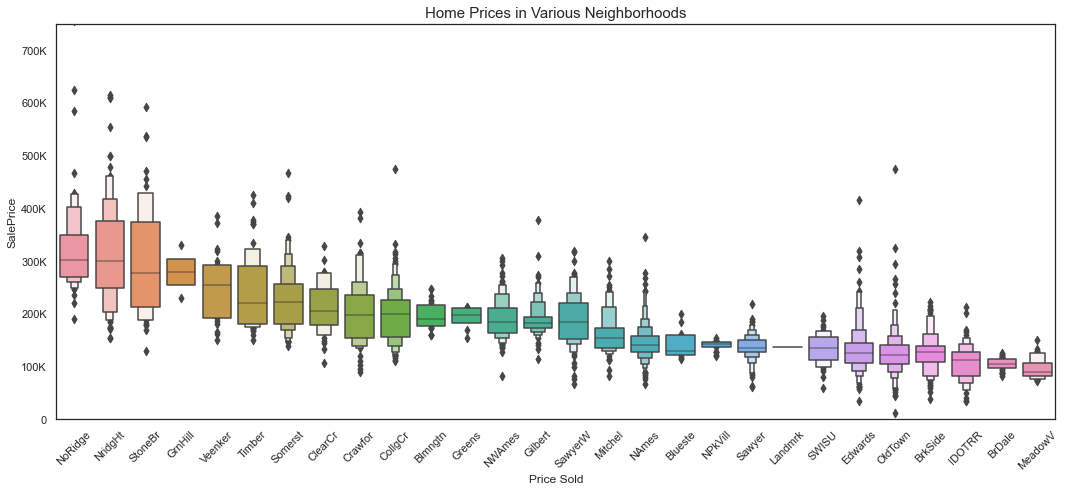

In [20]:
# home prices vs. neighborhoods

fig = sns.boxenplot(y = 'SalePrice', x = 'Neighborhood', data = housing, 
                    order = housing.groupby('Neighborhood').agg(
                        {'SalePrice':'mean'}).sort_values('SalePrice', ascending=False).index)
fig.set(ylim = (0, 7.5e5), xlabel = 'Price Sold', 
        yticklabels = ['0', '100K', '200K', '300K', 
                       '400K', '500K', '600K', '700K'])
fig.set_xticklabels(fig.get_xticklabels(), rotation=45)
plt.title('Home Prices in Various Neighborhoods', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Neighborhood, Boxplot.png', dpi = 600)
plt.show()

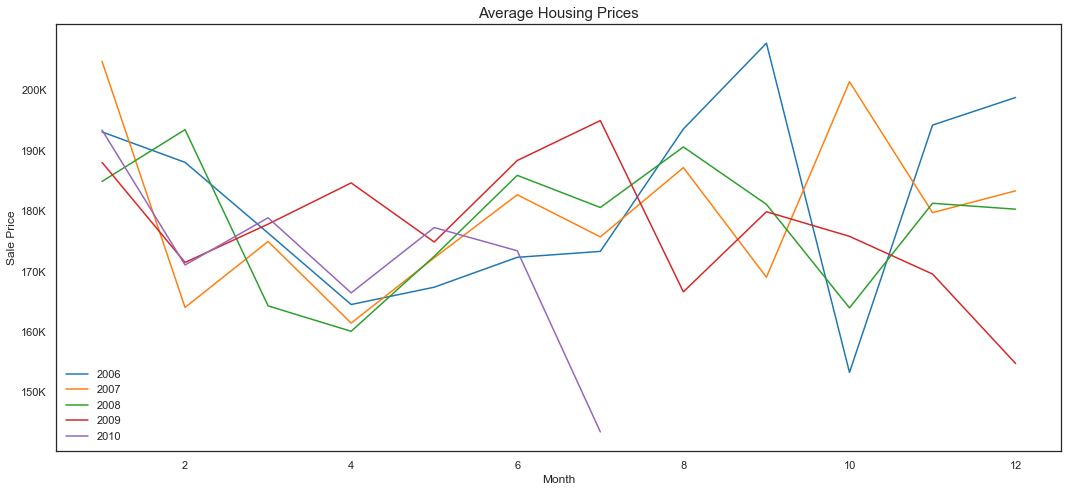

In [21]:
# home prices vs. neighborhoods

fig = sns.lineplot(x = 'MoSold', y = 'SalePrice', data = housing, 
                   hue = 'YrSold', palette="tab10", ci=None)
fig.set(yticklabels = ['', '150K', '160K', '170K', 
                       '180K', '190K', '200K'],
        xlabel = 'Month', ylabel = 'Sale Price')

plt.legend(frameon=False)
plt.title('Average Housing Prices', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Housing Prices, Lineplot.png', dpi = 600)
plt.show()

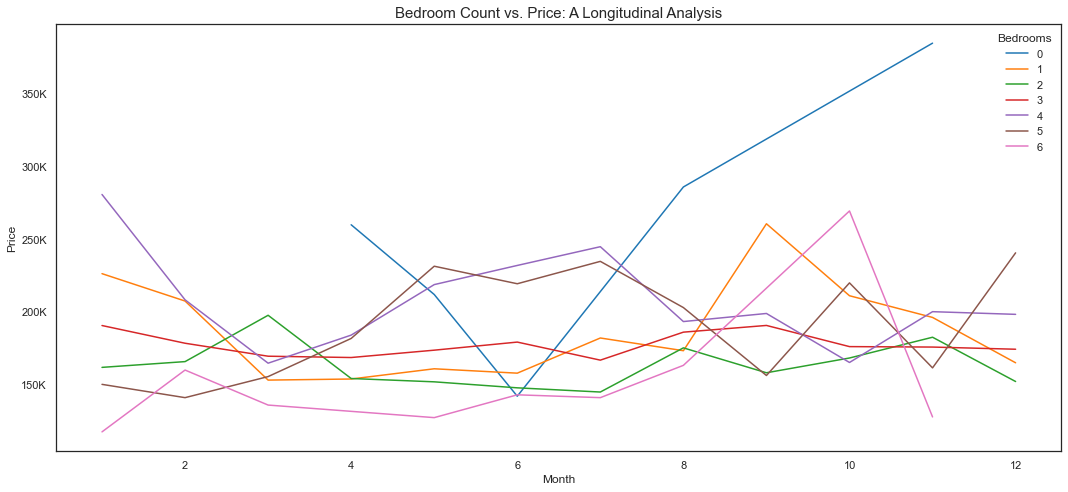

In [22]:
data = housing.groupby(['BedroomAbvGr', 'YrSold', 'MoSold']).agg({'SalePrice':'mean'}).reset_index()

fig = sns.lineplot(x='MoSold', y='SalePrice', data=data, 
                   hue='BedroomAbvGr', palette='tab10', ci=None)
fig.set(yticklabels=['', '150K', '200K', '250K', '300K', '350K'],
        xlabel='Month', ylabel = 'Price')

plt.legend(title='Bedrooms', frameon=False)
plt.title('Bedroom Count vs. Price: A Longitudinal Analysis', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Dwellings, Lineplot.png', dpi = 600)
plt.show()

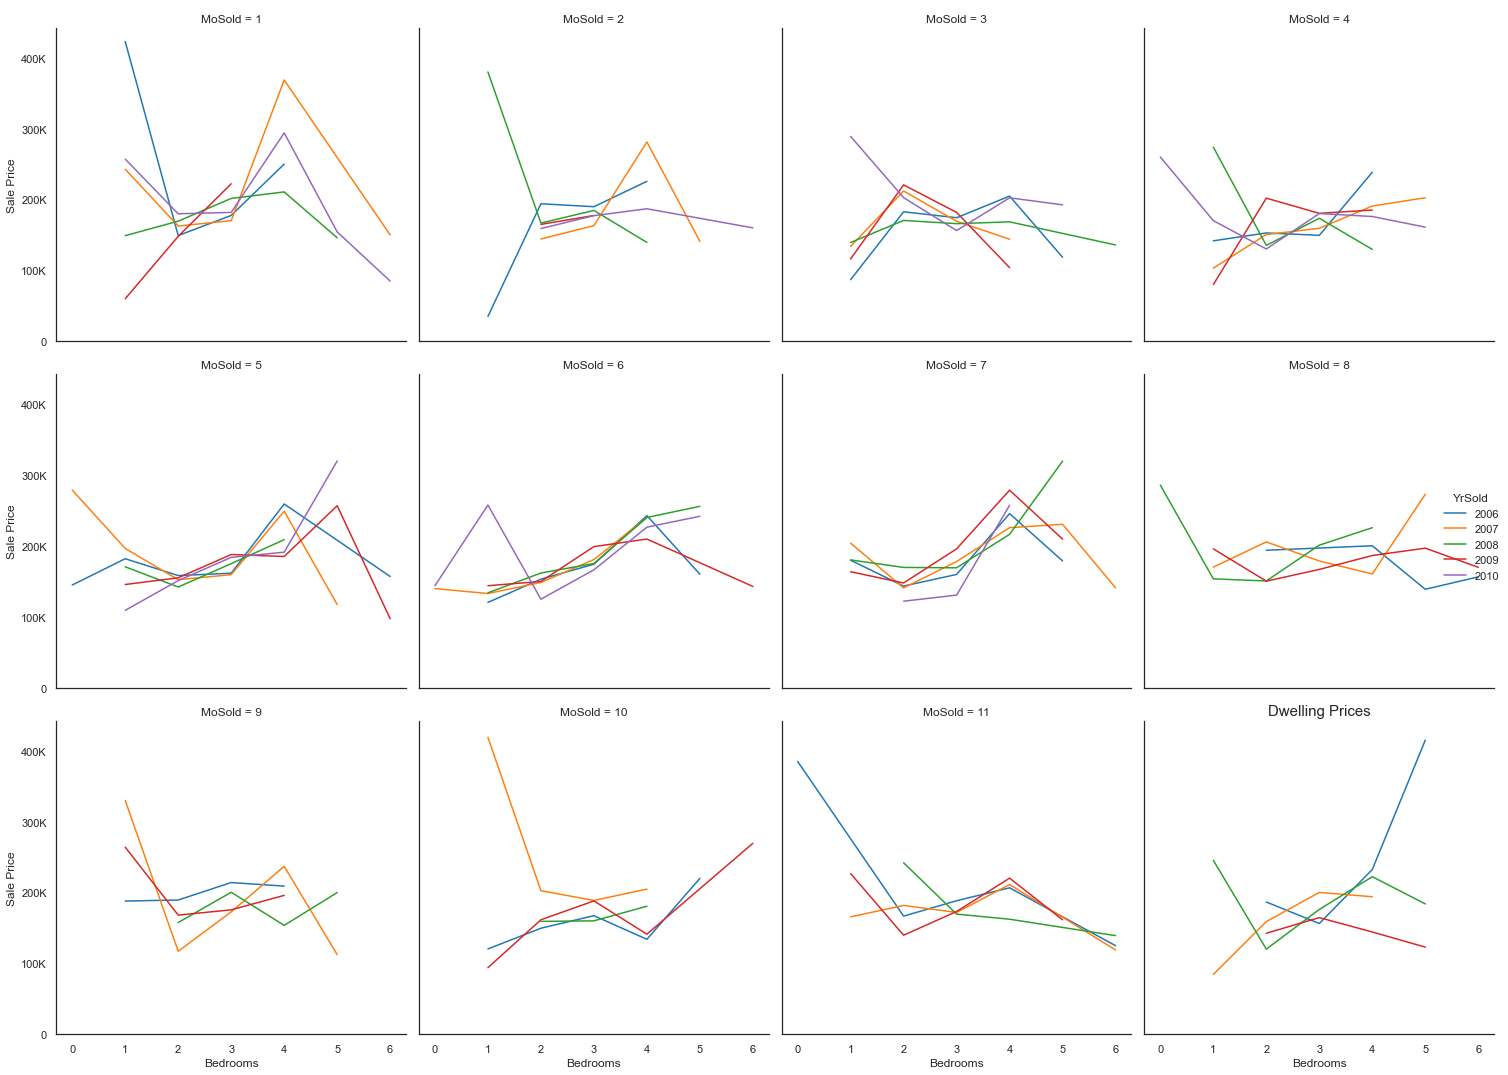

In [45]:
data = housing.groupby(['YrSold', 'MoSold', 'BedroomAbvGr']).agg({'SalePrice': 'mean'}).reset_index()

fig = sns.relplot(x='BedroomAbvGr', y='SalePrice', data=data, hue = 'YrSold', 
                  kind='line', ci=False, col='MoSold', palette='tab10',
                  col_wrap=4)
fig.set(xlabel='Bedrooms',
        ylabel='Sale Price',
        yticks=[0, 1e5, 2e5, 3e5, 4e5],
        yticklabels=['0', '100K', '200K', '300K', '400K'])
fig.add_legend(bbox_to_anchor = (1, 1), loc='upper right')
plt.title('Dwelling Prices', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Dwellings, FacetLine2.png', dpi = 1000)
plt.show()

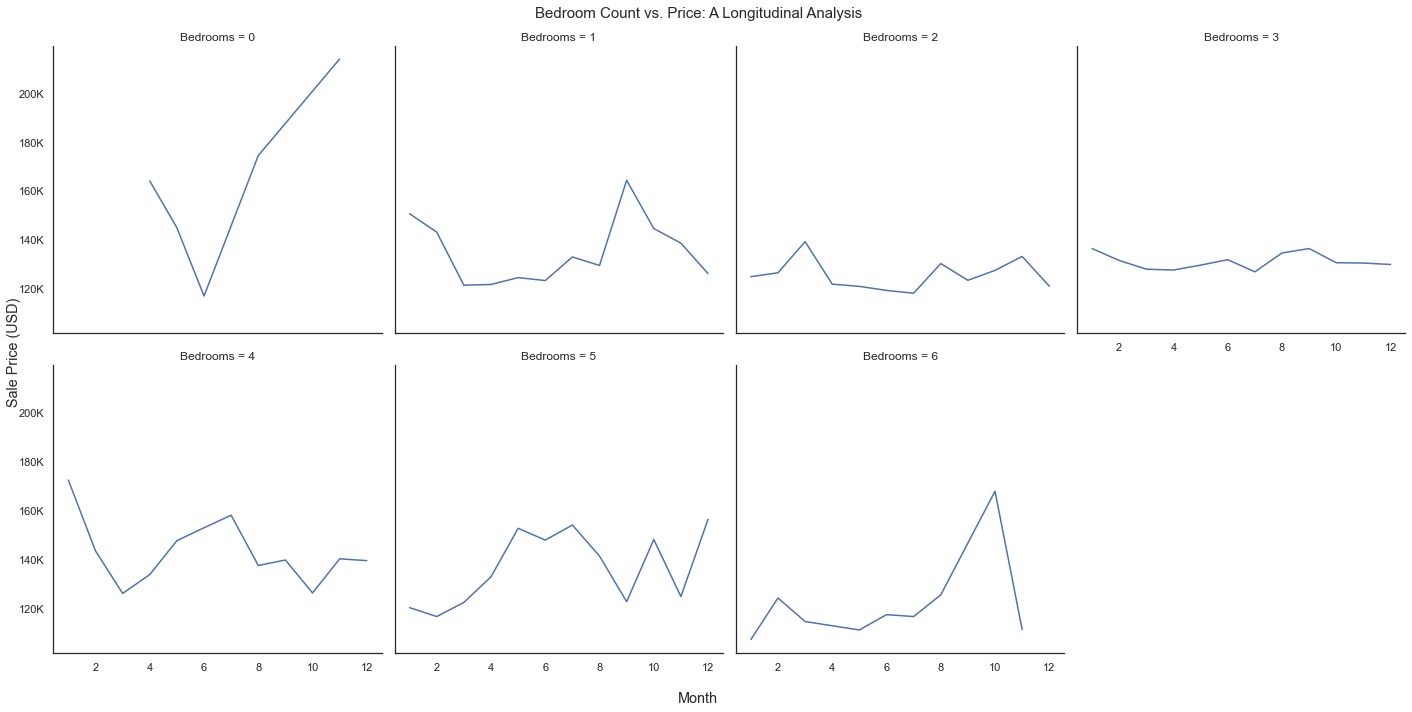

In [46]:
data = housing.groupby(['BedroomAbvGr', 'YrSold', 'MoSold']).agg({'SalePrice':'mean'}).reset_index()
data = data.rename({'BedroomAbvGr': 'Bedrooms'}, axis=1)

fig = sns.relplot(x='MoSold', y='SalePrice', col='Bedrooms', col_wrap=4,
                  data=data, kind='line', palette='tab10', ci=None)
fig.set(yticklabels = ['', '120K', '140K', '160K', '180K', 
                       '200K', '220K', '240K', '260K', '280K'],
        xlabel = '', ylabel = '')
fig.fig.supxlabel('Month')
fig.fig.supylabel('Sale Price (USD)')
fig.fig.suptitle('Bedroom Count vs. Price: A Longitudinal Analysis', fontsize=15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Dwellings, FacetLine.png', dpi = 600)
plt.show()

In [ ]:
# for col in housing.columns:
#     print(f'{housing[col].value_counts()}')

# for col in housing.columns:
#     print(f'{col}: {len(housing[col].value_counts())}')

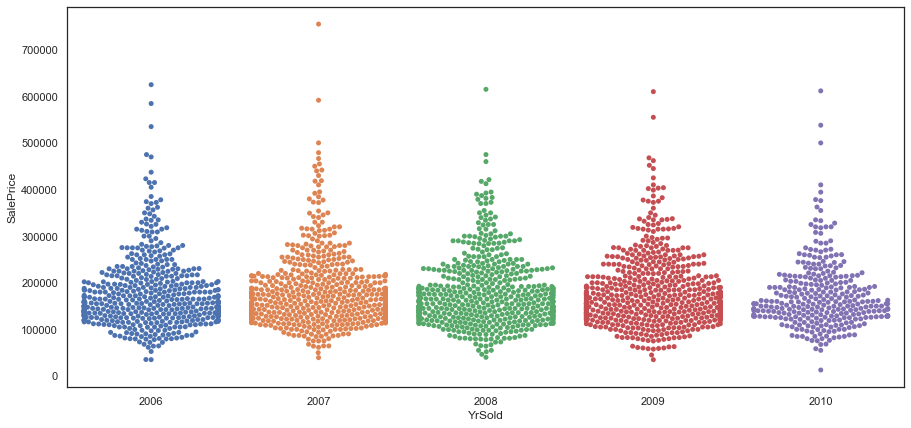

In [30]:
fig = sns.swarmplot(x = 'YrSold', y = 'SalePrice', data = housing)

# Machine Learning

###### Time Series Analysis

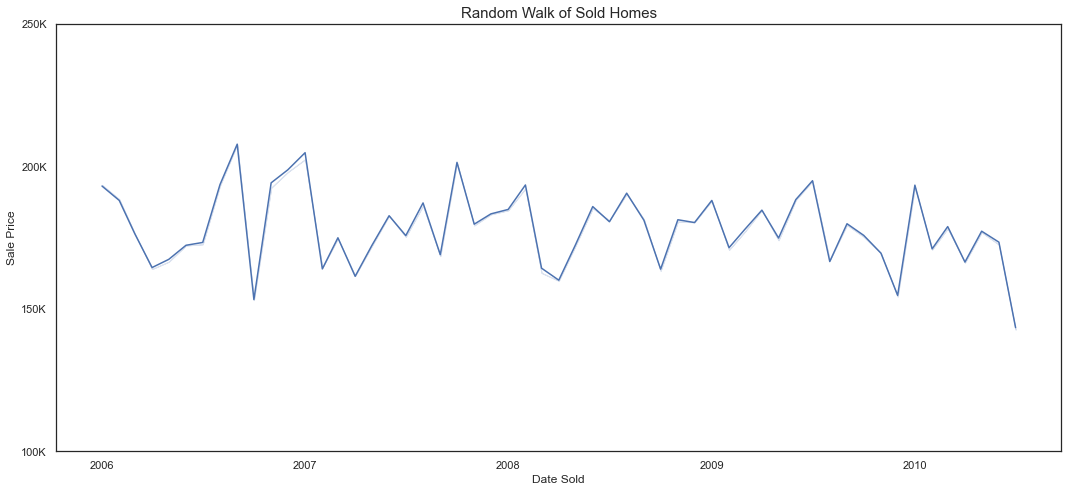

In [35]:
housing['DateSold'] = pd.to_datetime(housing['YrSold'].astype('str') 
                                 + '-' + housing['MoSold'].astype('str') + '-1')

data = housing[['DateSold', 'SalePrice']]

fig = sns.lineplot(x='DateSold', y='SalePrice', data=data, ci=False)
fig.set(xlabel='Date Sold',
        ylabel='Sale Price',
        xticks=['2006-01', '2007-01', '2008-01', '2009-01', '2010-01'],
        xticklabels=list(range(2006, 2011)),
        yticks=[1e5, 1.5e5, 2e5, 2.5e5],
        yticklabels=['100K', '150K', '200K', '250K'])
plt.title('Random Walk of Sold Homes', fontsize = 15)
plt.tight_layout()
plt.savefig('./visualizations/EDA - Timeseries DateSold, Lineplot.png', dpi = 1000)
plt.show()

In [50]:
df = housing.copy()
df.index = housing['DateSold']
df.drop('DateSold', axis=1, inplace=True)

data = df['SalePrice']

In [51]:
data

DateSold
2010-03-01    126000
2009-02-01    139500
2007-11-01    124900
2009-05-01    114000
2009-11-01    227000
               ...  
2009-05-01    121000
2009-06-01    139600
2007-08-01    145000
2007-07-01    217500
2006-09-01    215000
Name: SalePrice, Length: 2580, dtype: int64

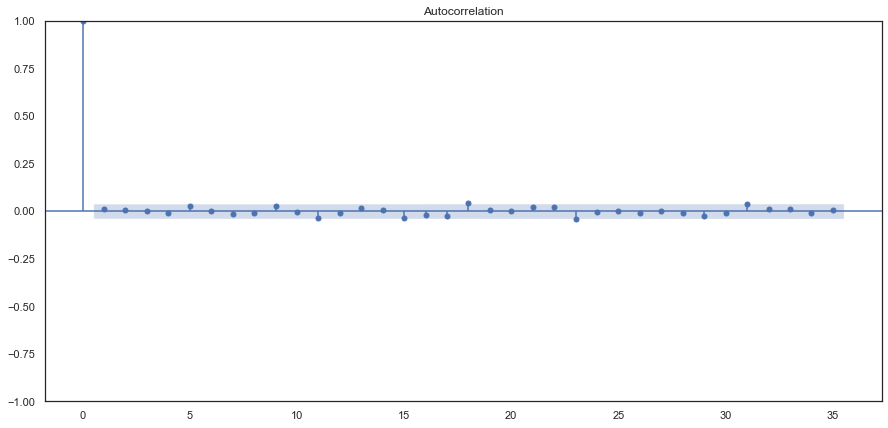

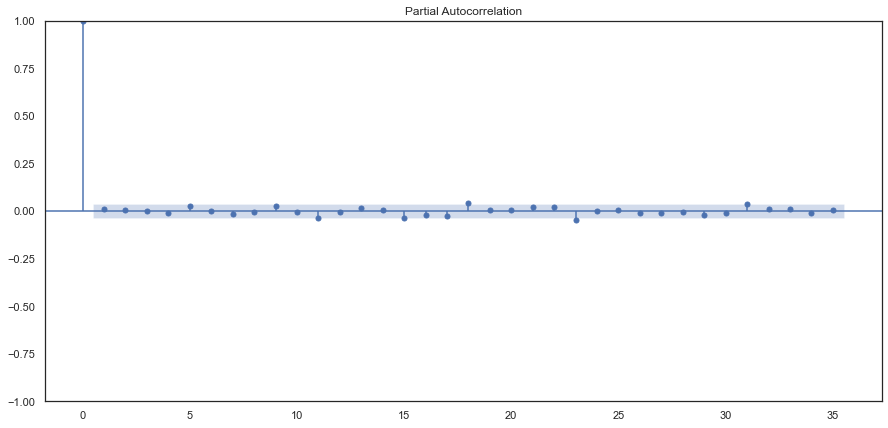

In [54]:
tsaplots.plot_acf(data)
tsaplots.plot_pacf(data)
plt.show()

In [39]:
ad_fuller_result = adfuller(data)
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -50.124285240692025
p-value: 0.0


In [56]:
realty['YrSold_YYYY'].value_counts()

2019.0    899
2017.0    896
2018.0    840
2020.0    331
Name: YrSold_YYYY, dtype: int64

# Machine Learning Project - Ames Housing Data

Ames, Iowa is the college town of **Iowa State University**. The Ames housing dataset consists of about $2500$ house sale records between $2006-2010$. Detailed information about the house attributes, along with the sale prices, is recorded in the dataset. The goal of the project is to:
- perform descriptive data analysis to gain business (i.e. housing market) insights
- build descriptive machine learning models to understand the local housing market.
- build predictive machine learning models for the local house price prediction.

A subset of the **Ames** dataset is hosted on [**Kaggle**](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) as an entry-level regression competition. You may visit their site for some information on the meanings of its data columns (the data dictionary). In this notebook, we will describe various project ideas related to this data.

## Who You Are

You can choose (but are not limited to) one of the following options:
- You are a housing market consultant.
- You are a data scientist for an online real estate database company which provides house price estimation (like **Zillow** home price estimates) for the site visitors.

No matter what angle you choose, your goal is to build a highly accurate predictive or descriptive model. To accomplish this, it is important to understand the local housing market in a **data driven** way. Your data analytics should be an objective analysis backed by your data!

## The Project Workflow

- Starting with in-depth data analysis (mandatory) and data pre-processing, your team can choose to specialize in either:
     - $100\%$ descriptive modeling on home prices, or
     - say $40\%$ descriptive modeling and $60\%$ predictive modeling tasks on home prices.
     - It's OK to focus on other areas, but these areas must align with your end-goal in your job-search.


- Tools you are expected to use:
   - **Data analysis and missing value imputation**: **pandas**, **dplr**, and the accompanying visualization tools, some multiple linear regression or logistic regression.
   - **Descriptive models**: feature selection, feature engineering, multiple linear regression, Python statsmodels or their R couterpart, penalized linear regression, stepwise regression (**AIC**, **BIC**, etc.), some gridsearch, KNN, SVR, Random Forest, Gradient Boosting, and potentially other models.
   - **Predictive models**: feature selection, feature engineering, gridsearchCV, multiple/penalized linear regression, gridsearch, Random Forest, Gradient Boosting, and potentially other models.


You can use machine learning models beyond those we list above, but don't make these optional models your first priority. Doing this would limit your time spent on the more fundamental part of the project. This is not wise!

The art of **feature engineering** includes generating new features, or selecting optimal features to feed into the machine learning models. If your goal is to improve accuracy, then the **optimal** features would mean the feature combination that offers high predictive accuracy. However, if your goal is to fit an **optimal** descriptive model for the purpose of improving business efficiency/profitability, the most accurate model might not give you the insights you want. As a modeler, you need to gauge which is most appropriate based on your objectives.


Clever ideas for **feature generation** are often inspired by high quality data analysis. Thus, we will suggest a few research questions to point you in the right direction. Chronologically, your team should work on data analysis and modeling simultaneously. Do **not** wait to start modelling until after you complete your data analysis phase, you will be pressed for time.

In [ ]:
housing

In [ ]:
realty.head()

In [ ]:
# tier and range is only one value: 0
realty.drop(['Tier', 'Range'], axis = 1)


#dummification
# ZngCdPr: Zoning Code, Primary: 26 factors, including NaN
# ZngCdSc: Zoning Code, Secondary: 9 factors, including NaN
# ZngCdPr: Zoning P&Z Overlay / Floating, Primary: 10 factors, including NaN
# ZngCdSc: Zoning P&Z Overlay / Floating, Secondary: 3 factors, including NaN
# ClassPr_S: Assessor Classification, Primary

In [ ]:
housing.columns

## The Data

There are two data sets included in the data folder: `Ames_Housing_Price_Data.csv` and `Ames_Real_Estate_Data.csv`.

The `Ames_Housing_Price_Data.csv` set contains $81$ data columns, including the key feature **SalePrice** which will be used as the target of the predictive/descriptive modeling. **PID** refers to the land parcel ID, which can merged on the *MapRefNo* column of the **Ames Accessor Data** (`Ames_Real_Estate_Data.csv`) to find the property address. Using a free service, such as **geopy**, we can find the long-lat coordinates of the houses.

The columns of the data are mostly attributes associated with the land and the houses. There are size related attributes, quality and condition attributes, house attachment attributes, etc.

To establish a foundation for your team's data analytics, we offer some insights on the house sizes vs. prices.

### How Does Price/SqrFt Play a Role in Housing Data Analytics?

In [ ]:
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression

In [ ]:
price        = housing['SalePrice']
size_related = housing.filter(regex='SF$|Area$')
size_related.head()

In [ ]:
size_related.isnull().sum(axis=0)

### Performing Unary Feature Selection

In [ ]:
size_related = size_related.fillna(0.0)  # We fill the very minor missing values by 0.0
F_values, p_values = f_regression(size_related, housing['SalePrice'])

pd.Series(p_values, index=size_related.columns).sort_values()

In [ ]:
import seaborn as sns
corr = pd.concat([size_related, housing['SalePrice']], axis=1).corr()
sns.heatmap(corr)

### GrLivArea 

Most of the size related columns have significant p-values on their correlations with **SalePrice**. The **Gross Living Area** (GrLivArea) has a vanishing p-value, which indicates a very strong statistical relationship. We will focus our research on **GrLivArea**.

In [ ]:
housing[['GrLivArea', 'SalePrice']].plot(kind='scatter', x='GrLivArea', y='SalePrice')

### A Large Variation in Price/SqrFt

The scatterplot above displays a fan-like structure which widens for larger houses. Considering straight lines through the origin, the slopes of these lines indicate the price per square-foot.

The above plot suggests a wide range of $price/foot^2$ among the houses in Ames. If we fit a naive simple linear model, the constant variance assumption of simple linear regression would be seriously violated.

The question is: how do we model this effectively? Luckily, pandas scatterplot has **logx** and **logy** arguments, which give us an important hint.

In [ ]:
housing[['GrLivArea', 'SalePrice']].plot(kind='scatter', x='GrLivArea', y='SalePrice', logx=True, logy=True)

After taking the log-log scatterplot, the fan-like structure disappears and the scatterplot can be approximated by a parallel family of line segments.

In [ ]:
lm = LinearRegression()
grLivArea = size_related[['GrLivArea']]
lm.fit(grLivArea, price)
lm.score(grLivArea, price)

In [ ]:
lm.fit(np.log10(grLivArea), np.log10(price))
lm.score(np.log10(grLivArea), np.log10(price))

### The Meaning of the Log-Log Linear Model

From a model goodness-of-fit standpoint, the log-log linear model offers a slightly better description of the data. We would like to study the meaning of the model.

What are the interpretations of the model intercept and slope? Unlike the original linear model which depicts that the sale price is proportional to the house gross living area, the log-log linear model offers totally different insights.

In [ ]:
lm.intercept_, lm.coef_

Schematically, the above log-log linear regression can be expressed as

$$log(price) = \beta_0 +\beta_1\cdot log(area) + \epsilon$$

or equivalently,

$$price = 10^{\beta_0} \cdot area^{\beta_1}\cdot 10^{\epsilon}$$

which we can then use to plug in our values

$${price\over area} = 10^{2.44}\cdot area^{-0.12}\cdot 10^{\epsilon}$$

This suggests an approximate formula for $price/ft^2$, which has been the yard-stick for all the housing transactions. Note that the negative exponent $-0.12$ above the area variable is $\beta_1-1$. The above formula suggests that $price/ft^2$ would drop for larger houses. In your data analytics, you should **investigate a plausible reason** for this price drop.

In [ ]:
Nbr_quantile = housing.groupby('Neighborhood')['GrLivArea'].quantile(0.8)
joint_Nbr_quantile = pd.merge(housing[['Neighborhood']], Nbr_quantile, how='left', left_on='Neighborhood', right_index=True)

In [ ]:
smaller_home = grLivArea.GrLivArea < joint_Nbr_quantile.GrLivArea
lm.fit(np.log10(grLivArea)[smaller_home], np.log10(price)[smaller_home])
lm.intercept_, lm.coef_

In [ ]:
lm.fit(np.log10(grLivArea)[~smaller_home],np.log10(price)[~smaller_home])
lm.intercept_, lm.coef_

### The Price Pressure on Larger Homes
The homes with living areas below the $80\%$ quantile **on average** follow a very simple relationship ${price\over area} \sim \$120/ft^2$. 

Larger homes (top $20\%$) follow a different relationship $${price\over area} \sim 29.5\cdot area^{0.16}$$
which is about $\$105$ for a $2500$ square-foot home.

This discount, or price pressure on larger homes, is why $\beta_1\sim 0.88$ if we aggregate all the homes together. In your data analysis, you should provide some clues about the origin of this price discount.

### A Reflection on the Various Choices in Modeling and Model Interpretation

Machine learning models help us to formulate **Ames** house prices schematically as 
$$price = F(feature1, feature2, \cdots,\epsilon)$$
where $\epsilon$ represents the residuals. As a modeler, you shape your model by deciding the features involved and the 
form of the function $F$. Is the relationship in the data linear or highly non-linear?

Naively, we may try to model the house price in terms of $price \sim \beta_1 area +\beta_0+\epsilon$.
Within this context, $\beta_1$ has the meaning of **price/square-foot** and $\beta_0$ is the
residual value (land, pavement, deck, pool, etc. of the house when the building disappears).

The expanding fan-like structure of the scatter plot implies very large residuals for larger homes. This makes the model a good approximation of the reality **only** when the house is very small.

On the other hand, we could fit either:
- $log(price)\sim \beta_1\cdot area + \beta_0 + \epsilon$
- $log(price)\sim \beta_1 \cdot log(area) + \beta_0 +\epsilon$.

### What Are the Major Implications of These Model Choices?

The former suggests $price \sim e^{\beta_1\cdot area}(e^{\epsilon+\beta_0})$, which treats
the **area** (GrLivArea) attribute as a dispensible attribute of a house. Even if $area=0$,
the home price fluctuates around a fixed residual value. The latter suggests $price \sim area^{\beta_1} e^{\beta_0+\epsilon}$, which implies that the house value vanishes if the house has NO gross living area at all.


This suggests a general principle on model interpretation: 
- If we run a simple linear regression of a feature (after suitable engineering),
$log(price)\sim \beta_{feature}feature + \beta_0+\epsilon$, this would imply
$price\sim e^{\beta_{feature}\cdot feature}\cdot e^{\beta_0+\epsilon}$, which treats the feature as an optional attribute of the house.
- If we model $log(price)\sim \beta_{feature}\cdot log(feature) +\beta_0+\epsilon$, 
this implies $price\sim {(feature)}^{\beta_{feature}} \cdot e^{\beta_0+\epsilon}$. Assuming
$\beta_{feature}>0$, this would imply a zero expected house value if $feature=0$. This implies that the feature is a very crucial attribute of a house.
- A multiple linear regression model $price\sim \sum \beta_iX_i+\epsilon$ implies that the
expected house price is the sum of the individual components.
- A log-linear model $log(price)\sim \sum_i \beta_iX_i+\epsilon$ implies that the expected house price is a product of independent factors $e^{\beta_i \cdot X_i}$.

In modeling **Ames** house prices using linear regression, your model design should be built upon your solid rationale for the dyanamics of the local housing market. This observation suggests that for the sake of simplicity of interpretation, it is better to group multiple highly correlated features together instead of treating them as separate features. This is in perfect agreement with the need to drop the feature dimension to reduce multi-collinearity (in the **Ames** data set, we have over 80 features).

### A Remark on Descriptive vs Predictive ML Modeling

- A **descriptive machine learning model** aims to describe the data (in our context, the **Ames** housing market), to generate (business) insights. Descriptive modeling is used by data analysts and data scientists.
- A **predictive machine learning model** aims to forecast the house prices based on the house features. A strong model is one which offers the best model prediction performance. Predictive modeling is used by data scientists and data engineers.
- Depending on your career track objectives, you should decide as a team whether to build a model for description (insights), for prediction accuracies, or work on both.

### Data Analysis Ideas Beyond Basic EDA

**Central Question**: The simple linear model based on **GrLivArea** points to $price/ft^2$ as an important derived target. On the other hand, the fan-like price/square-foot scatterplot implies that different houses have a wide range of $price/ft^2$. We would like to study the major driving factors for these **Ames** homes to have significantly different $price/ft^2$.

No matter which local housing market we inspect, the house prices are the on-going consensus among the home-buyers and 
the home-sellers depending on the supply and demand of the current house market. The house market supply and demand
is influnced by the local labor market/economical condition, job creation, population density, interest rate, price momentum, etc. Among all the area related features (e.g. 1st floor area, 2nd floor area, basement finished area, etc.), do
the local home buyers show some preference towards some features over the others? In other words, are the home buyers
willing to spend an equal amount for one square-foot of 1st floor living space, 2nd floor living space,
deck space, finished basement space, etc.?

Frame your study using **multiple linear regression** and interpret your findings in terms of
the price discounts. Consider the following points:
- Which of the house styles, ranch or colonial, is more popular in terms of the house prices?
- What is the popularity in terms of the housing inventory (based on the available data)?
- Does the house price sensitivity on **2ndFlrSF** depend on the house style (1st story excluded)?
- How is **GrLivArea** engineered from the other area-related feature? If you would design a gross area feature (to replace **GrLivArea**) for the purpose of descriptive modeling, what would you do? What are the pros and cons when aggregating several features together?
- Do home buyers value upstairs bathrooms and basement bathrooms equally? Do they price 'half-bath' as one half of a full bath? Based on your finding, how would you design an aggregate bathroom feature? 
- How much premium were the **Ames** home buyers (back in $2006-2010$) willing to pay for a swimming-pool, an open deck, or an enclosed porch? Did the home buyers value the optional additions based on their sizes?
- How important is a garage in adding value to the houses? How about the differences between an attached vs. detached garage?
- Are there feature combinations which increase the house values? What are the feature combinations which drive the house values down (making the house less desriable)? 
- **House Quality/Condition**: The **Ames** dataset grades each house by the appearance, kitchen, basement, garage, 
    heating, fireplace, .... and finally an overall quality/condition. 
     - How are the overall quality/condition features engineered from the individual quality/condition metrics?
     - How do these metrics' importances affect local house prices?
     - To what extent does the **curb appeal** affect the house prices?
- Does home remodeling add value to the houses? For example, how do the old houses which were remodeled in the 1990s compare to the houses which were built in the 1990s?

### Neighborhood Analysis

Many home buyers purchase their homes based on their neighborhood preferences and the location. Study the statistics on all the **Ames** neighborhoods, including prices, price/area, lot area, gross living area, built year, the ratios of one-story homes, the lot utility rate (how much of the lot is utilized to build the house), various quality/condition metrics, house styles, etc. Please depict a story of the urban development of **Ames** and relate it to the **Ames** house prices.

To get familiar with the various **Ames** neighborhoods and the ratings of the public schools, visit the map tab of [realtor.com](https://www.realtor.com/realestateandhomes-search/North-Ames_Ames_IA?view=map). While there are many housing info web sites, **realtor.com** uses a neighborhood system which is more compatible with the one used in the dataset. Getting the long-lat coordinates of the $2500$ houses also helps to pin-point the relative geographic locations of the neighborhoods.

Consider the following questions:
- Does the price sensitivity on quality depend on the neighborhood?  
- Given that **Ames** has about $30\%$ poverty rate, and that **ISU** is the largest employer of the city, identify the affluent and poor neighborhoods based on your data analysis and the external information. Identify the neighborhoods which offer a convenient job commute.
- What types of dwelling are popular in **Ames**? How about their popularities in the different neighborhoods?
- **Time Series Analysis**:  
    - During $2006-2010$, does **Ames** housing market show any pricing trend? Is your observation consistent with the fact that the great recession occured in $2008-2009$.
    - How would you describe the price tend of different types of dwellings in terms of time series (hint: pivot/pivot_table)?
    - In the U.S., there are more house-shopping activities during the warmer seasons (spring/summer). What is the seasonality of **Ames** house transactions?

In [ ]:
realty.head()

In [ ]:
housing.head()

To Dummify:
- MSSubClass: building class
    - 16 factors
- MSZoning: general zoning classification
    - 7 factors
- Street
    - 2 factors (Pave: 63, Grvl: 105, NaN: 2412)
- LotShape
    - 4 factors (Reg, IR1, IR2, IR3)
- LotContour
    - 4 factors (Lvl, HLS, Bnk, Low)
- Utilities
    - 2 factors (AllPub: 2578, NoSewr: 2)
- LotConfig
    - 5 factors (Inside, Corner, CulDSac, FR2, FR3)
- LandSlope
    - 3 factors (Gtl, Mod, Sev)
- Neighborhood
    - 28 factors


Continuous
- LotFrontage (changed NaN to 0)


In [ ]:
housing_raw.head()

In [ ]:
housing['LotFrontage'] = housing['LotFrontage'].fillna(0)

In [ ]:
housing

In [ ]:
column = 'Condition2'
print(housing[column].value_counts())
housing[column].isnull().value_counts()

In [ ]:
print(housing['MSSubClass'].value_counts())
housing['MSSubClass'].isnull().value_counts()

### Descriptive Modeling Ideas

The goal of a descriptive housing price model is to build a pricing model to describe the pricing rationale (the consensus of the home buyers/sellers), to describe the key driving factors that affect house prices, and to understand how they affect the local home prices. While prediction accuracy is welcome, the main objective is to gain insights on the local houing market to improve business. Apparently, the demographics inform what types of housing configurations are more popular. A house price model leads to a better understanding on the dynamics of the **Ames** housing market.

- **Feature Interaction**: In the framework of linear models, the nonlinear feature interactions
    need to be engineered by the data analyst/scientist manually. On the other hand, nonlinear
    models can pick up feature-feature interactions internally.
    - R offers a convenient way for modeling the feature interaction in the context of linear models, visit this [link](https://www.r-bloggers.com/r-tutorial-series-regression-with-interaction-variables/) for more information.
    - Here are two more online resources: [interplot](https://cran.r-project.org/web/packages/interplot/vignettes/interplot-vignette.html), [Interaction Effects in Regression](https://blog.clairvoyantsoft.com/dealing-with-interaction-effects-in-regression-db647ed38691).
    - In your (linear) pricing model, are there any feature-pair interactions? Does adding the feature-interaction term improve your model's descriptive power? Note that some of your data analysis will offer you hints on possible feature-feature interactions (categorical-quantitative interactions).
    - If you build a non-linear pricing model, the **partial_dependence_plot** in sklearn (illustrated in the PML Gradient Boosting lecture code) or the **ICE plot** of the Python [**PDPBox** package](https://towardsdatascience.com/introducing-pdpbox-2aa820afd312) will help you to identify the candidate feature-feature interactions.


- **Neighborhood Comps**: It is a very common practice for the home buyers to estimate the worth of the target home using the so-called 'neighborhood comp(atible)s.'
    - Using the nonlinear **KNN** (or its variant **RadiusNN**), rbf-kernel **SVR** or tree-based models, build a baseline neighborhood comp model based on the houses' long-lat coordinates (and maybe with the house-types). Apparently this naive nonlinear model does not offer the full story behind house pricing. Your goal is to build a secondary pricing model (using the house attributes) modeling the residuals of the neighborhood comp. By building an enhanced neighborhood comp model, you should be able to gauge its relevance in house pricing, as well as identify the complementary features which help improve the model.
    - Does your enhanced comps model offer valuable insights on the home buyers' purchase rationale?


- **Transaction Time**: The **YrSold** and **MoSold** are the two features related to the transaction time.
    - How would you build a model involving transaction time? What insights do you gain in this process?  


- Model selection on linear models can be done by using adjusted $R^2$, **AIC/BIC** or by cross validation.
- In using **GridSearchCV** to tune the hyperparameters of your models, be sure to value the internal consistency of your models over the test-set predictive accuracies.
- It is good to self-reflect upon the pros and cons of the approaches you adapt. 

### Predictive Modeling Ideas

The goal of building a predictive model is to predict the house prices accurately (just like Zillow home price estimates), rather than to understand the housing market dynamics. So the so-called **black box** models can be considered if they offer better accuracies.

- Because the number of features is large, multi-collinearity plagues multiple linear regression.
- Ridge, Lasso, and linear kernel SVR are popular choices to start your research.
- Use Lasso for feature selection if it is warranted.
- On the other hand, non-linear models, particularly tree-based models, are popular choices.
- **Ensembles**: If you train multiple models, you can put them into an ensemble to improve accuracies.
- If you borrow your insights in data analysis to generate new features, be sure to prevent **data-leakage**, i.e. you avoid using the cv test set house price values in your feature engineering analysis.

### Practical Applications For Your Models

- **Student Apartment Rental**: A company would like to purchase multiple rental houses in **Ames** to rent to **ISU** students. Based on your data analysis and your models, please give advice to your client regarding the target neighborboods, the house types, and the profit margin estimations. 
    - The **Ames** property tax is about $1.5\%$ of the market values. See [here](https://www.cityofames.org/government/departments-divisions-a-h/city-assessor/estimate-your-property-tax) for details.
    - The estimated annual maintenance cost is about $2\%$ of your property value.


- **House Hunting** for a new **ISU Professor**: A new professor at **ISU** plans to buy his home for his family of four (him, his spouse, and two teenagers). He will tolerate a max of half an hour commute to work daily. You do not need to consider his spouse's commute time. Please advise him regarding the price ranges and the target neighborhoods for better schools.


- **Business Intelligence** for the **Home Builder/Flipper**: A new home builder/old house remodeler would like to get into building new homes or flipping older houses for profit. Based on your modeling result, provide insights for your client. This is a more difficult question because it is hard to estimate building costs.

### Downloading the Lat-Long Coordinates with geopy
- pip install **geopy**
- use rate_limiter to slow down the download speed.

In [ ]:
import geopy
from geopy import Nominatim
from geopy.extra.rate_limiter import RateLimiter

locator = Nominatim(user_agent="myGeocoder")
location = locator.geocode("Champ de Mars, Paris, France")
location

- Wrap the raw geocoder by a rate-limiter, to prevent it from being blocked.

In [ ]:
geocode = RateLimiter(locator.geocode, min_delay_seconds=1.5)

- Given a list (or series) of street addresses (or nan value) in Ames, 

`locations = [geocode(addr+', Ames, USA') if type(addr)==str else None for addr in stree_addresses]`

### How to Compute the Distances between Two Long-Lat Coordinates?

- There are packages (like **geopy**) which allow you to compute the spherical distances. 
- For the purpose of machine learning, it is desirable to let the $L^2$ Euclidean distance (used by the algorithm) approximate the spherical distance. This can be very handy in neighborhood comps modeling.
- Let $(\theta_1, \phi_1)$ and $(\theta_2, \phi_2)$ be two points on the sphere (the earth). When these two points are sufficiently close to each other, $\theta_1\cong \theta_2$ and $\phi_1\cong\phi_2$. For simplicity we assume that the sphere has a radius $1$ (The earth radius is about $3950$ miles). The spherical distance $\Delta s$ can be approximated by the following formula:

$$\Delta^2 s = cos^2(\phi)\Delta^2\theta + \Delta^2\phi$$

where $\phi\cong \phi_1\cong\phi_2\cong 42^{\circ}$ at **Ames**.

This suggests that if we map the long-lat coordinates $(\theta_i, \phi_i), 1\leq i\leq 2$ to $(cos(\phi)\theta_1, \phi_1)$, $(cos(\phi)\theta_2, \phi_2)$,
the 2D Euclidean distance is an approximation of the spherical distance.